<a href="https://colab.research.google.com/github/tayfununal/PyTorch/blob/main/05_mnist_nice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch import nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

In [2]:
class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset[idx]
        return x

In [3]:
"""class Data(Dataset):
    def __init__(self, dataset):
        super(Data, self).__init__()

        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x = self.dataset.data[idx]
        y = self.dataset.targets[idx]
        return x, y"""

'class Data(Dataset):\n    def __init__(self, dataset):\n        super(Data, self).__init__()\n\n        self.dataset = dataset\n\n    def __len__(self):\n        return len(self.dataset)\n\n    def __getitem__(self, idx):\n        x = self.dataset.data[idx]\n        y = self.dataset.targets[idx]\n        return x, y'

In [4]:
class NICE(nn.Module):
    def __init__(self, input_dim, hidden_layer, num_flows=2):
        super(NICE, self).__init__()

        self.input_dim = input_dim
        self.hidden_layer = hidden_layer
        self.num_flows = num_flows

        self.net = lambda : nn.Sequential(
                                 nn.Linear(self.input_dim//2, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.hidden_layer), nn.ReLU(), nn.BatchNorm1d(self.hidden_layer),
                                 nn.Linear(self.hidden_layer, self.input_dim//2)) # input dimension must be equal to output dimension

        self.m = nn.ModuleList([self.net() for _ in range(self.num_flows)])

        self.s = nn.Parameter(torch.rand(1, input_dim), requires_grad=True)

        self.per_list = self.permutation()

    def forward(self, x):
        x = x.view(len(x), -1,).to(torch.float32)
        return self.f(x)

    def permutation(self):
        per_list =[]

        p = torch.eye(self.input_dim)
        for flow in range(self.num_flows):
            per_list.append(p[torch.randperm(p.size()[0])])

        return per_list

    def coupling_layer(self, x, m, flow, forward=True):

        x_a = x[:, ::2] if flow%2==0 else x[:, 1::2]
        x_b = x[:, 1::2] if flow%2==0 else x[:, ::2]

        if forward:
            y_b = x_b - m(x_a)
        else:
            y_b = x_b + m(x_a)

        #z = torch.concat((x_a, y_b), axis=1) if flow%2==0 else torch.concat((y_b, x_a), axis=1)
        z = torch.empty(x.shape)
        z[:, ::2] = x_a if flow%2==0 else y_b
        z[:, 1::2] = y_b if flow%2==0 else x_a
        return z


    def f(self, x):
        z = x / torch.exp(self.s)

        for flow, model in enumerate(self.m, start=0):
            z = torch.matmul(z, self.per_list[flow])
            z = self.coupling_layer(z, model, flow, forward=True)

        log_det_j = torch.sum(-self.s)

        return z, log_det_j

    def f_inv(self, z):

        for flow, model in reversed(list(enumerate(self.m, start=0))):
            z = self.coupling_layer(z, model, flow,forward=False)
            z = torch.matmul(z, self.per_list[flow].T)

        x = z * torch.exp(self.s)
        return x

    def criterion(self, z, prior, log_det_j, reduction = "sum"):

        if reduction == "sum":
            loss = - (prior.log_prob(z) + log_det_j).sum()
        else:

            loss = - (prior.log_prob(z) + log_det_j).mean()
        return loss

In [5]:
def rescale(x, lo, hi):
    """Rescale a tensor to [lo,hi]."""
    assert(lo < hi), "[rescale] lo={0} must be smaller than hi={1}".format(lo,hi)
    old_width = torch.max(x)-torch.min(x)
    old_center = torch.min(x) + (old_width / 2.)
    new_width = float(hi-lo)
    new_center = lo + (new_width / 2.)
    # shift everything back to zero:
    x = x - old_center
    # rescale to correct width:
    x = x * (new_width / old_width)
    # shift everything to the new center:
    x = x + new_center
    # return:
    return x

In [6]:
train_image = torchvision.datasets.MNIST(root='dataset', train=True, download=True, transform=transforms.ToTensor())
test_image = torchvision.datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

X_train = train_image.data.type(dtype=torch.float32)
y_train = train_image.targets

X_test = test_image.data.type(dtype=torch.float32)
y_test = test_image.targets

# Dequantization
X_train = torch.tensor(X_train) + torch.rand_like(torch.tensor(X_train)).div_(256.)
X_train = rescale(X_train, 0., 1.).numpy()

100%|██████████| 9912422/9912422 [00:00<00:00, 57257750.14it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 26095582.47it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 22971422.77it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6689090.16it/s]


Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



<ipython-input-6-8d23df9458ef>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train) + torch.rand_like(torch.tensor(X_train)).div_(256.)


In [7]:
train_data = Data(X_train)
test_data = Data(X_test)

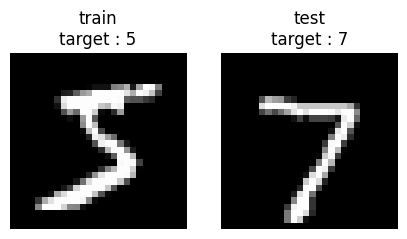

In [8]:
image_train = train_data[0]
category_train = y_train[0]
image_test = test_data[0]
category_test = y_test[0]

plt.figure(figsize=(5,5))
plt.subplot(1,2,1)
plt.imshow(image_train.reshape((28,28)), cmap='gray')
plt.title(f'train\ntarget : {category_train}')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(image_test.reshape((28,28)), cmap='gray')
plt.title(f'test\ntarget : {category_test}')
plt.axis('off')

plt.show()

In [9]:
data_dim = 28*28
prior = torch.distributions.multivariate_normal.MultivariateNormal(loc=torch.zeros((data_dim)),
                                                    scale_tril=torch.diag(torch.ones((data_dim))))
"""
prior = torch.distributions.normal.Normal(loc=torch.zeros((data_dim)),
                                                    scale=torch.ones((data_dim)))
"""
model = NICE(input_dim=data_dim, hidden_layer=256, num_flows=10)

train_loader = DataLoader(train_data, batch_size=10000, shuffle=True)


In [10]:
epochs = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)   # weight_decay=0.9

COST = []

for epoch in range(epochs):
    total_loss = []

    for x in train_loader:

        z, log_det_j = model.forward(x)
        loss = model.criterion(z, prior, log_det_j, reduction="avg")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss.append(loss.item())

    COST.append(np.mean(total_loss))

    if epoch==0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))
    elif (epoch+1)%10 == 0:
        print("Epoch : ", epoch+1, "  -----------> Loss : ", np.mean(total_loss))

Epoch :  1   -----------> Loss :  1633.629903157552
Epoch :  10   -----------> Loss :  979.253896077474
Epoch :  20   -----------> Loss :  782.4918212890625
Epoch :  30   -----------> Loss :  585.8950907389323
Epoch :  40   -----------> Loss :  390.04808044433594
Epoch :  50   -----------> Loss :  193.92272440592447
Epoch :  60   -----------> Loss :  2.0541271468003592
Epoch :  70   -----------> Loss :  -184.61337280273438
Epoch :  80   -----------> Loss :  -360.3739878336589
Epoch :  90   -----------> Loss :  -527.8745727539062
Epoch :  100   -----------> Loss :  -687.2193908691406
Epoch :  110   -----------> Loss :  -833.7474263509115
Epoch :  120   -----------> Loss :  -975.4815979003906
Epoch :  130   -----------> Loss :  -1102.6018473307292
Epoch :  140   -----------> Loss :  -1227.3664957682292
Epoch :  150   -----------> Loss :  -1335.9872639973958
Epoch :  160   -----------> Loss :  -1443.5686645507812
Epoch :  170   -----------> Loss :  -1532.8291625976562
Epoch :  180   -----

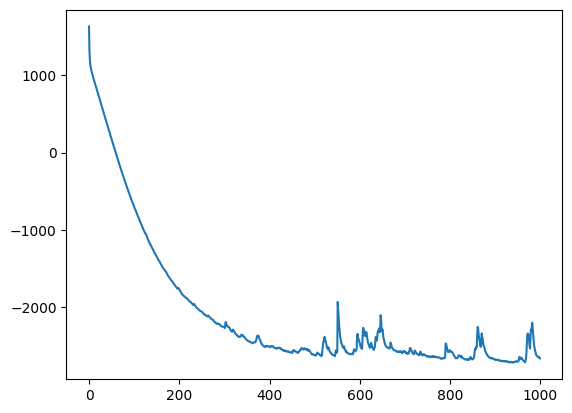

In [11]:
plt.plot(COST)

In [12]:
test = prior.sample((50,))
test

tensor([[-0.1261,  0.0170, -0.4511,  ...,  1.2161, -0.3747, -2.2427],
        [ 0.6095,  0.8064, -0.7912,  ...,  1.3883,  0.1375,  1.4389],
        [-0.2518, -0.2091, -0.2132,  ..., -1.1970,  0.3752, -0.0951],
        ...,
        [-1.4179, -1.3632, -1.1042,  ...,  0.6467, -0.3854, -0.1425],
        [ 1.4590,  2.1984, -0.9564,  ..., -1.1355,  0.1156, -0.3183],
        [ 1.7016, -0.0721,  0.4013,  ...,  1.7998,  0.6497,  0.5482]])

In [13]:
sonuc = model.f_inv(test)
sonuc

tensor([[ 1.1341e-05,  2.6154e-06,  5.6931e-06,  ...,  9.2961e-06,
          7.8501e-06,  1.8430e-05],
        [ 3.1214e-06,  1.1461e-05,  3.3463e-05,  ...,  5.1873e-06,
          8.1906e-06,  9.5199e-06],
        [ 4.1665e-06,  2.4265e-05, -1.1960e-05,  ...,  1.3553e-06,
          1.3847e-05, -5.7882e-06],
        ...,
        [ 2.9250e-06,  3.8292e-06, -1.9328e-06,  ...,  2.7445e-09,
          1.7116e-05,  1.6186e-06],
        [ 1.2916e-06,  1.3422e-05,  1.5046e-05,  ...,  7.0658e-06,
          6.2486e-06,  2.9631e-06],
        [ 7.2453e-06,  3.7174e-06,  8.8509e-07,  ...,  4.8412e-06,
          1.7948e-05,  8.1716e-06]], grad_fn=<MulBackward0>)

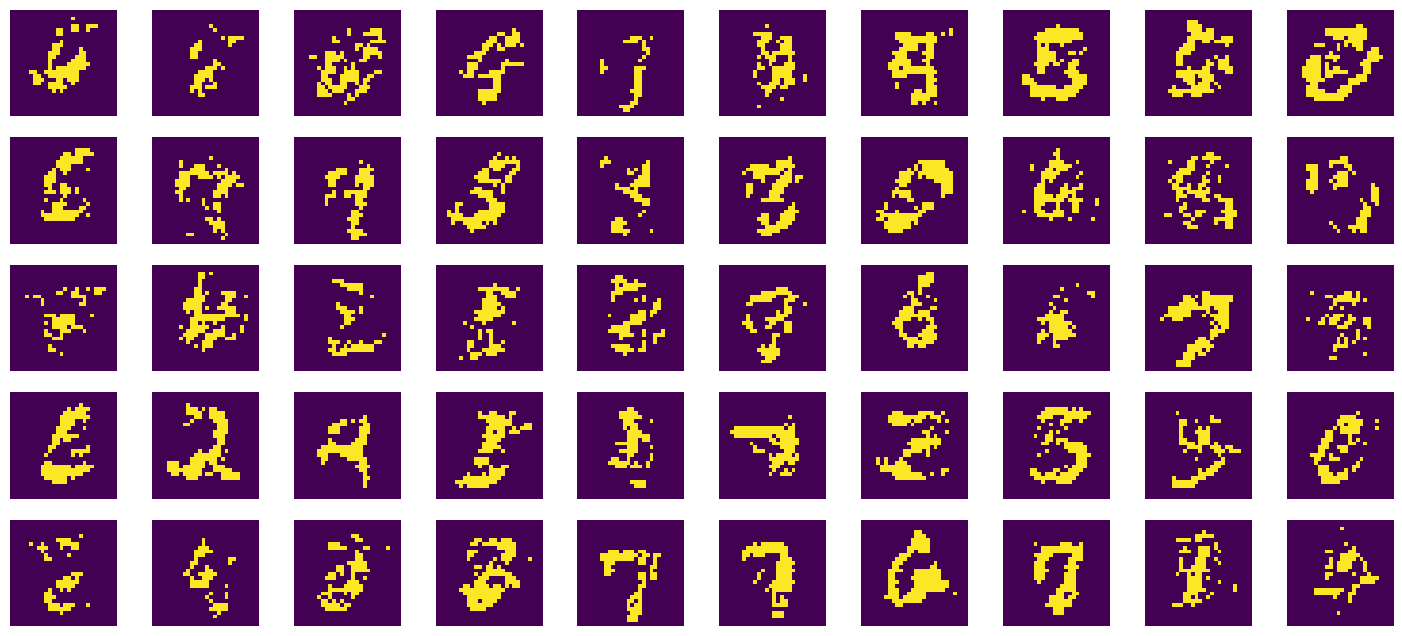

In [38]:
test = prior.sample((50,))
sonuc = model.f_inv(test)
sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)))
    axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')
    axs[3, i].axis('off')
    axs[4, i].axis('off')
fig.show()

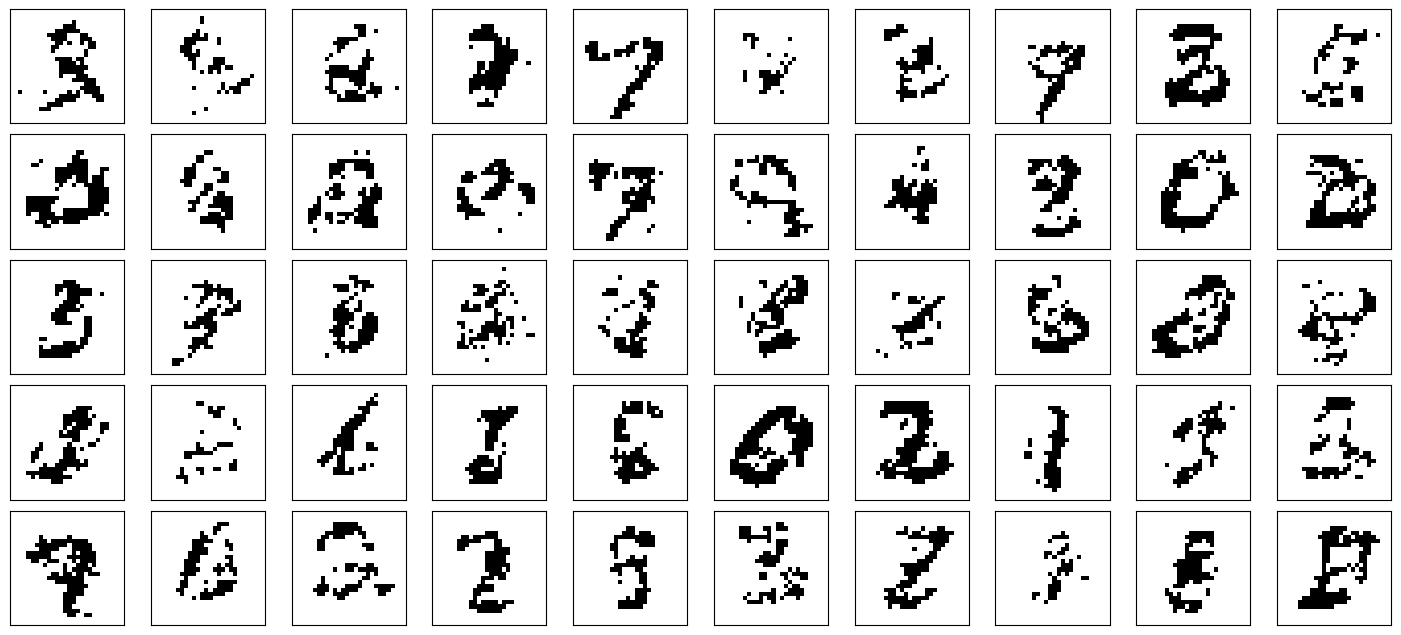

In [37]:
test = prior.sample((1797,))
sonuc = (model.f_inv(test))

sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()

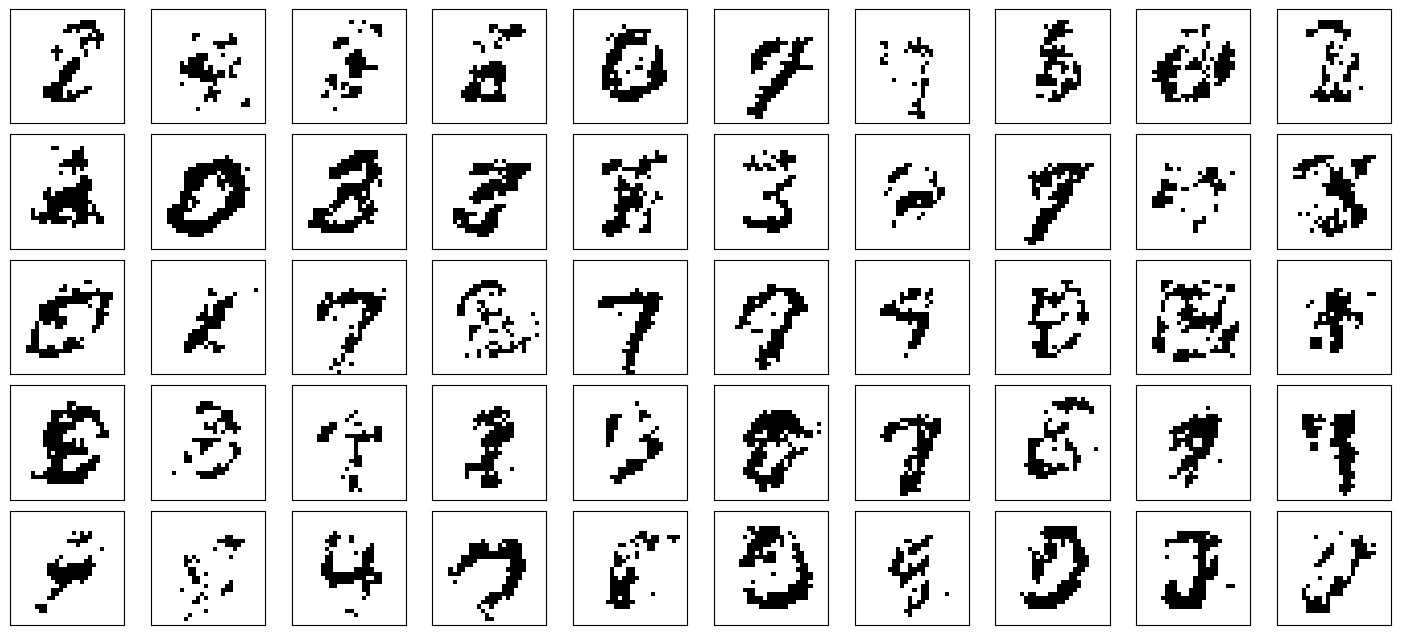

In [36]:
test = prior.sample((1797,))
sonuc = torch.abs(model.f_inv(test))
sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0

fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()

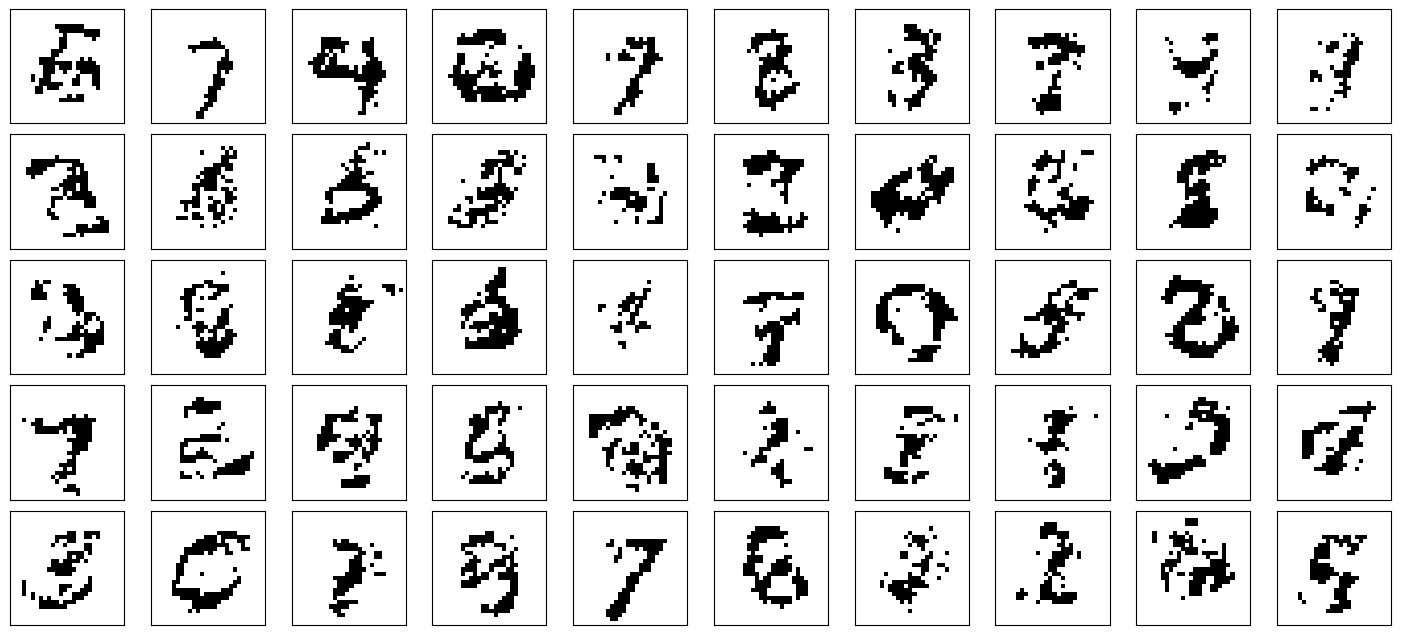

In [39]:
test = prior.sample((1797,))
sonuc = torch.nn.ReLU()(model.f_inv(test))
sonuc[sonuc[:]>=0.5] = 1
sonuc[sonuc[:]<0.5] = 0
fig, axs = plt.subplots(5, 10, sharex=True, sharey=True, figsize=(18, 8), subplot_kw={'xticks':[], 'yticks':[]}, gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i in range(0,10):

    axs[0, i].imshow((sonuc[i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[1, i].imshow((sonuc[10+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[2, i].imshow((sonuc[20+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[3, i].imshow((sonuc[30+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
    axs[4, i].imshow((sonuc[40+i]).detach().numpy().reshape((28,28)), cmap='binary', interpolation='nearest', clim=(0, 0.8))
fig.show()